# Working with Multielectrode Data in pandas

We're going to load in the multielectrode array data from a CSV file, do some EDA, and make some inferences with respect to our experimental questions. 



## Import packages

In [2]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Set/derive experiment parameters

need to move some down after we load data

In [3]:

# time_bins is used to define x axis in plots over time. We know that the trials went from 
#   150 ms pre-stimulus to 2000 ms post-stimulus onset. Here we specify a wider range, 
#   from -200 to 2500 ms (in 10 ms increments), to provide some padding.
time_bins = np.arange(-.2, 2.5, .01) 

# times the stimulus went on and off
grating_on_time  = 0
grating_off_time = 2

num_trials = len(data_in['DATA'])
all_ortn = [data_in['DATA'][t][0][1][0][0] for t in range(num_trials)] #intermediate variable
ortn_levs = list(set(all_ortn))
num_ortn = len(ortn_levs)

NameError: name 'data_in' is not defined

## Import the data


In [ ]:
df = read_csv('data/multielectrode_data.csv')

In [ ]:
df.head()


Whereas the data we imported from Matlab are in a somewhat Byzantine embedded format, pandas offers a more simple and intuitive format, often called **long format**, in which data are stored in a 2-dimensional matrix (rows and columns), with one data point per row. Each row comprises the data itself, and additional columns that label the data. 

For this data set, using pandas long format, we'll want columns for:
- channel (which electrode the data came from)
- sort code
- time (of spike)
- orientation
- trial number

One downside of long format is that it is not memory-efficient, since we have so many redundant labels. In contrast, think back to the `ten_intensities` data in previous sections of the chapter. That data was stored as a dictionary, with each entry in the dictionary being the contrast label. Therefore, the contrast label only had to be stored once in memory, and all the data inside the dictionary entry would be categorized as having that label. In contrast, every data point in pandas carries a copy of the intensity label, meaning more information is stored in memory. 

There are two significant downsides of less efficient memory storage. Firstly, that it takes more memory (RAM) on the system it's running on. In large data sets, the amount of RAM available (either on a computer or a cloud server) may actually become a limitation in the amount of data you can work with. Secondly, operations on the data tend to take longer, due to the larger amount of information that needs to be processed. Pandas is written to handle large data pretty efficiently, but it's not always the most efficient way of doing things. 

On the other hand, long data is very intuitive to work with, and avoids having to resort to the complex embedded data structure described above in decoding the Matlab file. And pandas is a great package to work with, as it provides a lot of powerful features for manipulating data, and grouping it by different properties and combinations of properties. These are tasks we routinely want to do in neural data science, and it becomes easier to work with different data sets and even types of data, if we consistently use a common framework like pandas. And in spite of its somewhat inefficient way of storing data, pandas is still highly optimized and generally quite fast. 

### Clean the data

We know from the provider of the data that sort codes 0 and 255 represent bad data, so above we defined these as `noise_codes`. Here we remove all rows that have these sort codes. Note that the `~` operator in front of a statement means "not". So here we are saying to keep in `df` only those rows where `sort` is *not* equal to one of the `noise_codes`.

In [5]:
df = df[~df['sort'].isin(noise_codes)]

Now let's view the DataFrame. Note the size: over 2 million entries!!!

In [6]:
df

,channel,sort,time,orientation,trial
0,20.0,1.0,0.624,90.0,0.0
1,20.0,1.0,0.630,90.0,0.0
2,20.0,3.0,0.652,90.0,0.0
3,20.0,3.0,0.659,90.0,0.0
5,20.0,1.0,0.689,90.0,0.0
...,...,...,...,...,...
1321,18.0,1.0,2.625,0.0,2299.0
1323,74.0,2.0,2.629,0.0,2299.0
1324,18.0,1.0,2.634,0.0,2299.0
1325,60.0,1.0,2.636,0.0,2299.0


### Exploring the data 
Let's see how many electrodes we have data from, and what their labels are. We save each as a variable, which will come in handy later in looping through these.

In [7]:
num_chan = df['channel'].unique().shape[0]
print('Number of electrodes (channels): ' + str(num_chan))

channels = sorted(df['channel'].unique())  # use the sorted() function so the channels are listed in sequential order
print('Channel labels: ' + str(channels))

Number of electrodes (channels): 91
Channel labels: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 32.0, 33.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0]


This is a bit weird — we're told this is a 96 electrode array, but there are only 91 electrodes?!  Nylen and Wallisch note that there were some 'dead' channels in the microarray that yielded no data. This is not uncommon as some electrodes in the microarray may be damaged during insertion. This is not a big deal, but it is worth keeping in mind when we look at the data.

What about orientations?

In [8]:
orientations = sorted(df['orientation'].unique())
num_ortns = len(orientations)
print('Found ' + str(num_ortns) + ' orientations, which are: ' + str(orientations))

Found 2 orientations, which are: [0.0, 90.0]


And sort codes?

In [9]:
sort_codes = sorted(df['sort'].unique())
print(sort_codes)

[1.0, 2.0, 3.0, 4.0]


We can also flex our pandas slicing and filtering skills to sample the data in different ways. For example, here's the data only from electrode number 20:

In [10]:
df[df['channel']==20.]

,channel,sort,time,orientation,trial
0,20.0,1.0,0.624,90.0,0.0
1,20.0,1.0,0.630,90.0,0.0
2,20.0,3.0,0.652,90.0,0.0
3,20.0,3.0,0.659,90.0,0.0
5,20.0,1.0,0.689,90.0,0.0
...,...,...,...,...,...
1180,20.0,3.0,2.079,0.0,2299.0
1184,20.0,1.0,2.093,0.0,2299.0
1192,20.0,3.0,2.105,0.0,2299.0
1217,20.0,1.0,2.236,0.0,2299.0


Taking that further, we can for example extract the spike times for a particular channel and orientation if we desire. Since the result is a single column, this returns a pandas Series rather than a DataFrame:

In [11]:
chan = 1
ortn = 0
df[(df['channel']==chan) & (df['orientation']==ortn)]['time']

7      -0.097
22     -0.079
755     0.949
1108    1.445
1371    1.965
        ...  
1009    1.683
1056    1.771
1172    2.032
1185    2.095
1220    2.246
Name: time, Length: 10283, dtype: float64

---
## Peri-Stimulus Time Histograms (PSTH)

In the previous chapters, we used NumPy's `hist` function to generate histograms, and then plotted them using Matplotlib functions. Now that we're storing our data in a pandas DataFrame, we can make use of convenient pandas functions for plotting, instead.

We can use pandas' `.hist()` method to obtain a PSTH, firstly just across all trials and electrodes/neurons, with the followig arguments:
- the values in the `time` column (spike times) are what are used to generate the histogram
- the `by` argument generates separate plots for each value in the orientation column
- the `time_bins` variable we set earlier defines the x axis of the histogram (`bins`); `time_bins` is in 10 ms increments so that becomes the size of our histogram bins
- `sharey` forces the y axis range to be the same across plots
- `layout` specifies 2 rows (each orientation) and one column
- `figsize` was determined by trial and error to provide a subjectively-nice aspect ratio and fit the figure in the notebook

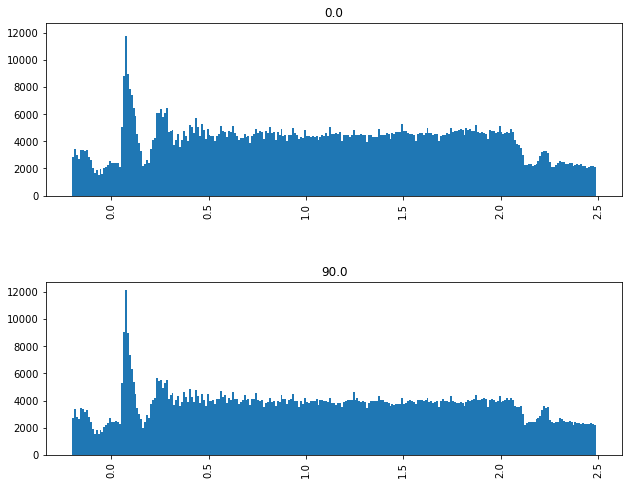

In [12]:
df.hist(column='time', 
        by='orientation', 
        bins=time_bins, 
        sharey=True, 
        layout=(2, 1),
        figsize=[10, 8]
       )
plt.show()

Since we know there are 4 sort codes, we can also plot by both orientation and sort code. Here we turn off the `sharey` option, because the number of spikes varies by sort code. 

We pass a list of two columns to `by` in order to break the data down by both `oriantation` and `sort`, and then we specify the `layout` as 2 rows (orientation) and 4 columns (sort).

**Note:** This is actually not a valid thing to do from the point of view of the experiment, because the sort codes are unique to individual channels. That is, spike sorting is applied separately to each channel's data, so for example `sort_code==1` does not refer to the same neuron in channels 1 and 2. However, right now our main goal is to demonstrate how to compute and plot the PSTHs separately along two dimensions. Below we'll do that in a valid way, for all channels, but that's a lot (91), so let's start small.

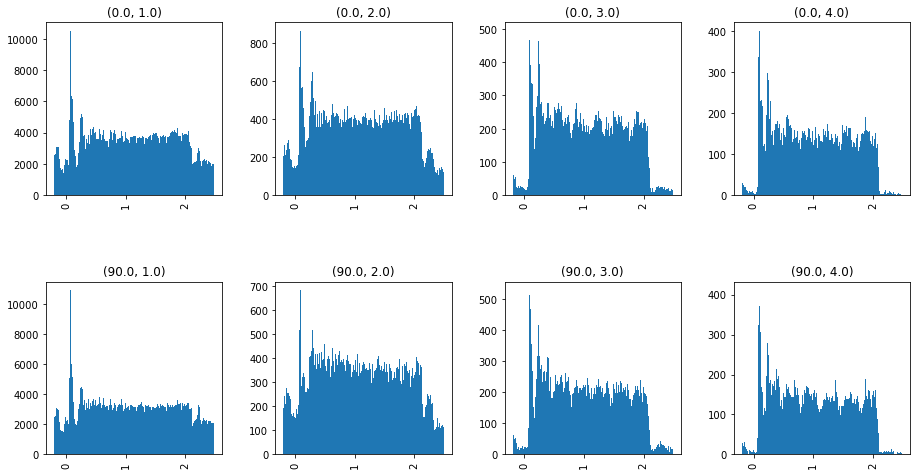

In [13]:
df.hist(column='time', 
        by=['orientation', 'sort'], 
        bins=time_bins, 
        sharey=False, 
        layout=(2, 4),
        figsize=[15, 8]
       )
plt.show()

### Pre-Computing PSTHs

Although pandas provides the convenient `.histogram()` method, this is not the most flexible way to generate a plot. We can also compute histograms using `np.histogram()`, without immediately plotting them — just the way we did with the `ten_intensities` data. We save these histograms in memory, which allows more flexibility in how we later plot them. To do this, we have to loop over orientations and sort codes, compute the histogram for each, and save these to plot later. 

We will store the PSTHs in a new pandas DataFrame, `psth_df`, with one row per PSTH. Each bin (time point) in the histogram will be a column, with additional columns to encode condition and sort code or channel.

First we create a DataFrame with columns that will serve as labels for the histograms:

In [14]:
condition_labels = pd.DataFrame([[ortn, sort] for sort in sort_codes for ortn in orientations ],
                               columns=['ortn', 'sort'])

condition_labels

,ortn,sort
0,0.0,1.0
1,90.0,1.0
2,0.0,2.0
3,90.0,2.0
4,0.0,3.0
5,90.0,3.0
6,0.0,4.0
7,90.0,4.0


Now we create a list of DataFrames, where each DataFrame is a single row containing the histogram for a particular sort_code and orientation. It is important that the order of the nested loops here, is the same as the order of the `for` statements in the list comprehension that generated the column labels above. Otherwise the labels won't correctly match the data.

In [15]:
psth_df_list = []
for sort in sort_codes:
    for ortn in orientations:
        spike_times = df[(df['sort']==sort) & (df['orientation']==ortn)]['time']
        hist, bins = np.histogram(spike_times,
                          bins=time_bins,
                         )
        psth_df_list.append(hist)
   

Concatenate the labels columns with the histograms. Note that inside the `pd.concat()` command, we've nested a command to combine the list of histogram DataFrames into a single DataFrame, which then gets combined with the column labels.

In [16]:
psth_df = pd.concat([condition_labels, pd.DataFrame(psth_df_list)], axis=1)        

In [17]:
psth_df

,ortn,sort,0,1,2,3,4,5,6,7,...,259,260,261,262,263,264,265,266,267,268
0,0.0,1.0,2573,3043,2651,2418,3079,3086,3016,3074,...,2185,2111,2128,2047,1996,1896,1975,2070,2016,1956
1,90.0,1.0,2462,3026,2539,2332,3112,3024,2909,2959,...,2218,2200,2132,2201,2111,2115,2107,2143,2099,2027
2,0.0,2.0,208,266,222,210,240,237,255,275,...,139,108,144,144,132,119,150,116,140,122
3,90.0,2.0,194,244,188,209,249,274,207,256,...,129,115,94,129,110,106,116,143,122,112
4,0.0,3.0,55,60,57,50,56,47,26,32,...,15,20,21,19,13,12,13,19,16,15
5,90.0,3.0,51,64,47,51,54,51,37,39,...,17,15,27,20,9,10,25,19,21,18
6,0.0,4.0,31,30,26,27,20,25,20,13,...,1,3,2,6,5,3,5,2,1,1
7,90.0,4.0,29,28,21,23,30,21,19,13,...,1,6,6,5,4,3,1,5,1,4


The last bit of formatting we can add to the DataFrame is to convert the columns that serve as labels (`ortn`, `sort`) to indexes. This has two advantages:
1. We can use the `.loc[]` method to select rows based on the labels, rather than the more-complex set of Boolean selectors on values in particular rows.
2. The "data" part of the DataFrame contains only PSTHs. This way, when we want to write code to access the data, we don't have to worry about excluding columns that were for labels. 

In [18]:
psth_df = psth_df.set_index(['ortn','sort'])
psth_df

,,0,1,2,3,4,5,6,7,8,9,...,259,260,261,262,263,264,265,266,267,268
ortn,sort,,,,,,,,,,,,,,,,,,,,,
0.0,1.0,2573,3043,2651,2418,3079,3086,3016,3074,2559,2290,...,2185,2111,2128,2047,1996,1896,1975,2070,2016,1956
90.0,1.0,2462,3026,2539,2332,3112,3024,2909,2959,2502,2151,...,2218,2200,2132,2201,2111,2115,2107,2143,2099,2027
0.0,2.0,208,266,222,210,240,237,255,275,290,268,...,139,108,144,144,132,119,150,116,140,122
90.0,2.0,194,244,188,209,249,274,207,256,256,259,...,129,115,94,129,110,106,116,143,122,112
0.0,3.0,55,60,57,50,56,47,26,32,22,27,...,15,20,21,19,13,12,13,19,16,15
90.0,3.0,51,64,47,51,54,51,37,39,18,26,...,17,15,27,20,9,10,25,19,21,18
0.0,4.0,31,30,26,27,20,25,20,13,8,10,...,1,3,2,6,5,3,5,2,1,1
90.0,4.0,29,28,21,23,30,21,19,13,5,8,...,1,6,6,5,4,3,1,5,1,4


### Plotting the Histograms

Now we can plot the histograms that we just completed. These should look similar to the panel of 8 histograms we plotted above; the big difference is that above we use pandas `.histogram()` method, whereas here we pre-computed the histograms so that we can use Matplotlib's more flexible and general-purpose `.plot()` function. This allows us more control and power in drawing the plot. For example, below we shade in the time period when the stimulus was on, and we draw the PSTHs as lines rather than bars. ALthough this may seem like something of an aesthetic preference, as you'll see below, lines give you the ability to overlay PSTHs for different conditions, allowing comparison.

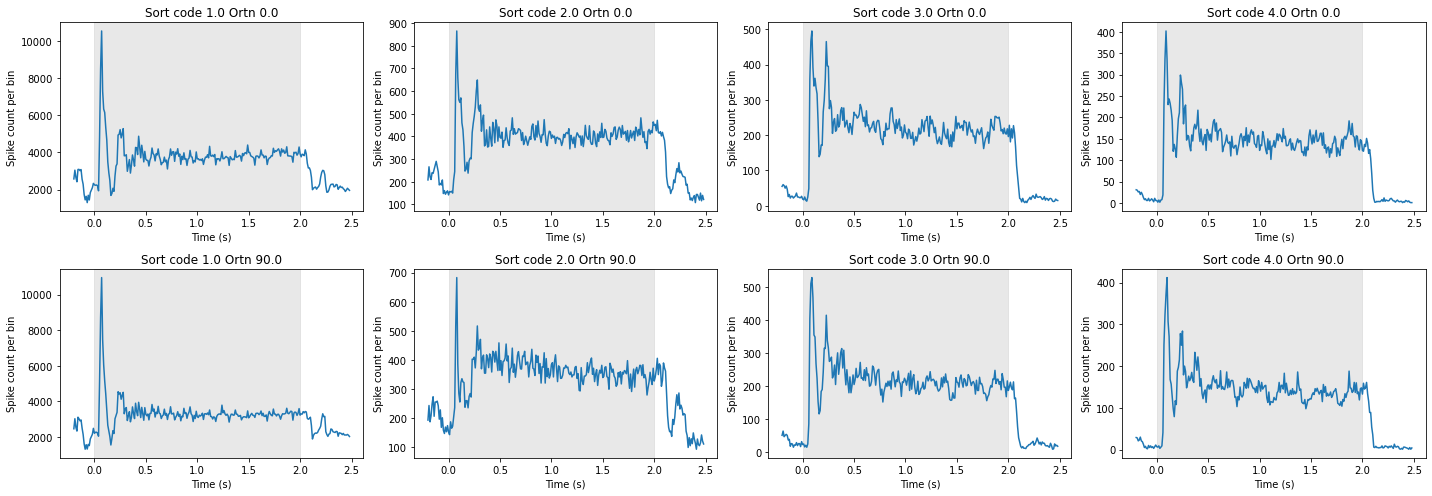

In [28]:
fig = plt.figure(figsize=[20,7])

# loop through rows in DataFrame
plot_counter = 1
for ortn in ortn_levs:
    for sort in sort_codes:
        ax = fig.add_subplot(len(ortn_levs), len(sort_codes), plot_counter)
        plot_counter += 1
        
        # use .loc[] to select appropriate rows to plot
        ax.plot(time_bins[:-1], 
                psth_df.loc[ortn, sort]
               )

        plt.axvspan(grating_on_time, grating_off_time, alpha=0.5, color='lightgray')
        ax.set_title('Sort code ' + str(sort) + ' Ortn ' + str(ortn))
        ax.set_ylabel('Spike count per bin')
        ax.set_xlabel('Time (s)')
        plt.tight_layout() 

plt.show()    

Note above the differences in total spike counts (*y* axis ranges) between sort codes. This is because the data are summed over channels; every channel as at least a sort code of 1 (i.e., contains data from one neuron/unit), but fewer channels were found to contain data from two or more units. So decreasing amounts of data contribute to the averages for sort codes 1-4.

### Overlaying Conditions

It's easier to make visual comparisons within a plot than between them. Since 0 and 90 degrees were the two experimental conditions that we'd want to compare, let's overlay them, keeping the separate panels for sort code. 

Note that this is a bit easier to do using the list method rather than the dictionary method, because in our list of labels, the orientation and sort code are two separate entries, so it's easy to pull out the orientations. Using the dictionary method, we'd need to parse the dictionary keys to pull out the orientation information.

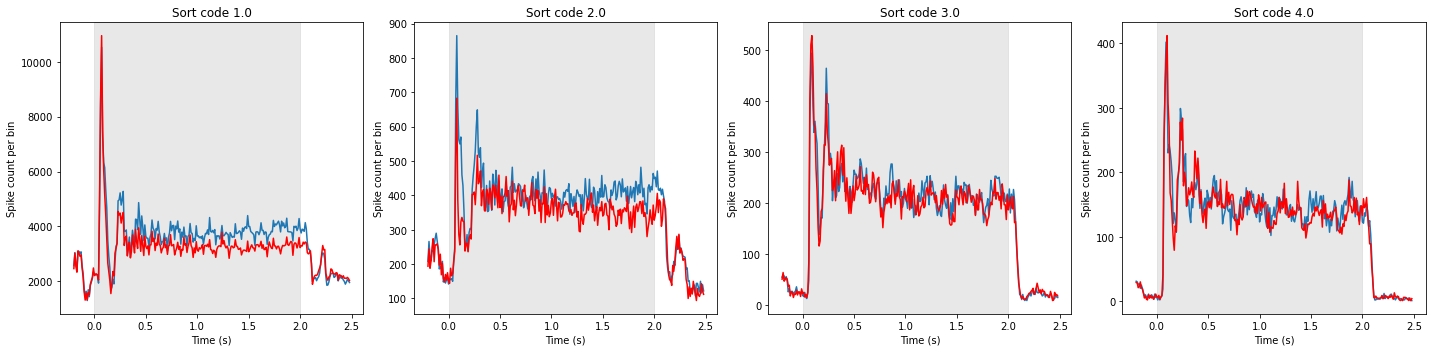

In [29]:
fig = plt.figure(figsize=[20,5])

for sort in sort_codes:
    ax = fig.add_subplot(1, len(sort_codes), int(sort))

    # One little trick here is for the second argument (histogram), we need to 
    # "squeeze" the result of the Boolean selector on the DataFrame so that it's a Series
    ax.plot(time_bins[:-1], 
           psth_df.loc[ortn_levs[0], sort]
           )

    ax.plot(time_bins[:-1], 
           psth_df.loc[ortn_levs[1], sort],
           color='red'
           )

    plt.axvspan(grating_on_time, grating_off_time, alpha=0.5, color='lightgray')
    ax.set_title('Sort code ' + str(sort))
    ax.set_ylabel('Spike count per bin')
    ax.set_xlabel('Time (s)')
    plt.tight_layout() 
    
plt.show()    

---
## PSTH for each channel

The above examples collapsed across all 96 channels in the microelectrode array. This was for simplicity of plotting only 4 sort codes. Let's now compute the PSTHs for each channel and orientation. 

In [30]:
condition_labels = pd.DataFrame([[ortn, chan] for chan in channels for ortn in orientations ],
                               columns=['orientation', 'channel'])

psth_list = []
for chan in channels:
    for ortn in orientations:
        hist, bins = np.histogram(df[(df['channel']==chan) & (df['orientation']==ortn)]['time'],
                          bins=time_bins,
                         )
        psth_list.append(hist)
        
psth = pd.concat([condition_labels, pd.DataFrame(psth_list)], axis=1)    

# Make orientation and channel indexes rather than data columns
psth = psth.set_index(['orientation','channel'])

psth

,,0,1,2,3,4,5,6,7,8,9,...,259,260,261,262,263,264,265,266,267,268
orientation,channel,,,,,,,,,,,,,,,,,,,,,
0.0,1.0,14,32,22,14,29,28,56,74,60,59,...,19,12,12,13,16,16,15,19,21,11
90.0,1.0,15,32,19,18,26,40,42,54,38,51,...,15,17,22,14,27,21,19,21,18,17
0.0,2.0,2,3,0,6,2,2,0,3,1,1,...,1,1,1,0,1,0,0,2,0,0
90.0,2.0,3,1,3,2,2,4,5,2,5,5,...,3,2,1,0,2,2,3,1,2,0
0.0,3.0,8,1,3,3,6,4,4,8,5,2,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90.0,94.0,2,2,0,2,0,0,1,3,1,1,...,0,0,1,0,0,0,0,0,0,0
0.0,95.0,0,1,1,1,0,0,0,0,0,1,...,0,1,1,3,0,0,0,1,1,0
90.0,95.0,1,2,1,4,0,2,2,2,1,0,...,1,0,2,1,1,1,0,0,1,1


### Plot all channels

To plot these, we use similar code to above. However, because there are 96 channels, we want to remove some axis labels from most plots (so it's less messy and less redundant). There's no way to make this not a huge image, since there are 96 panels to show, but by setting it to 4 columns we attain a good balance between readability and size.

In the loop below, we access specific data to plot form the pandas DataFrame [using `.loc`](https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#selection-by-label) to select based on the index columns. Since the index columns are in the order `['orientation', 'channel']` we specify the arguments to `.loc` in the same order.

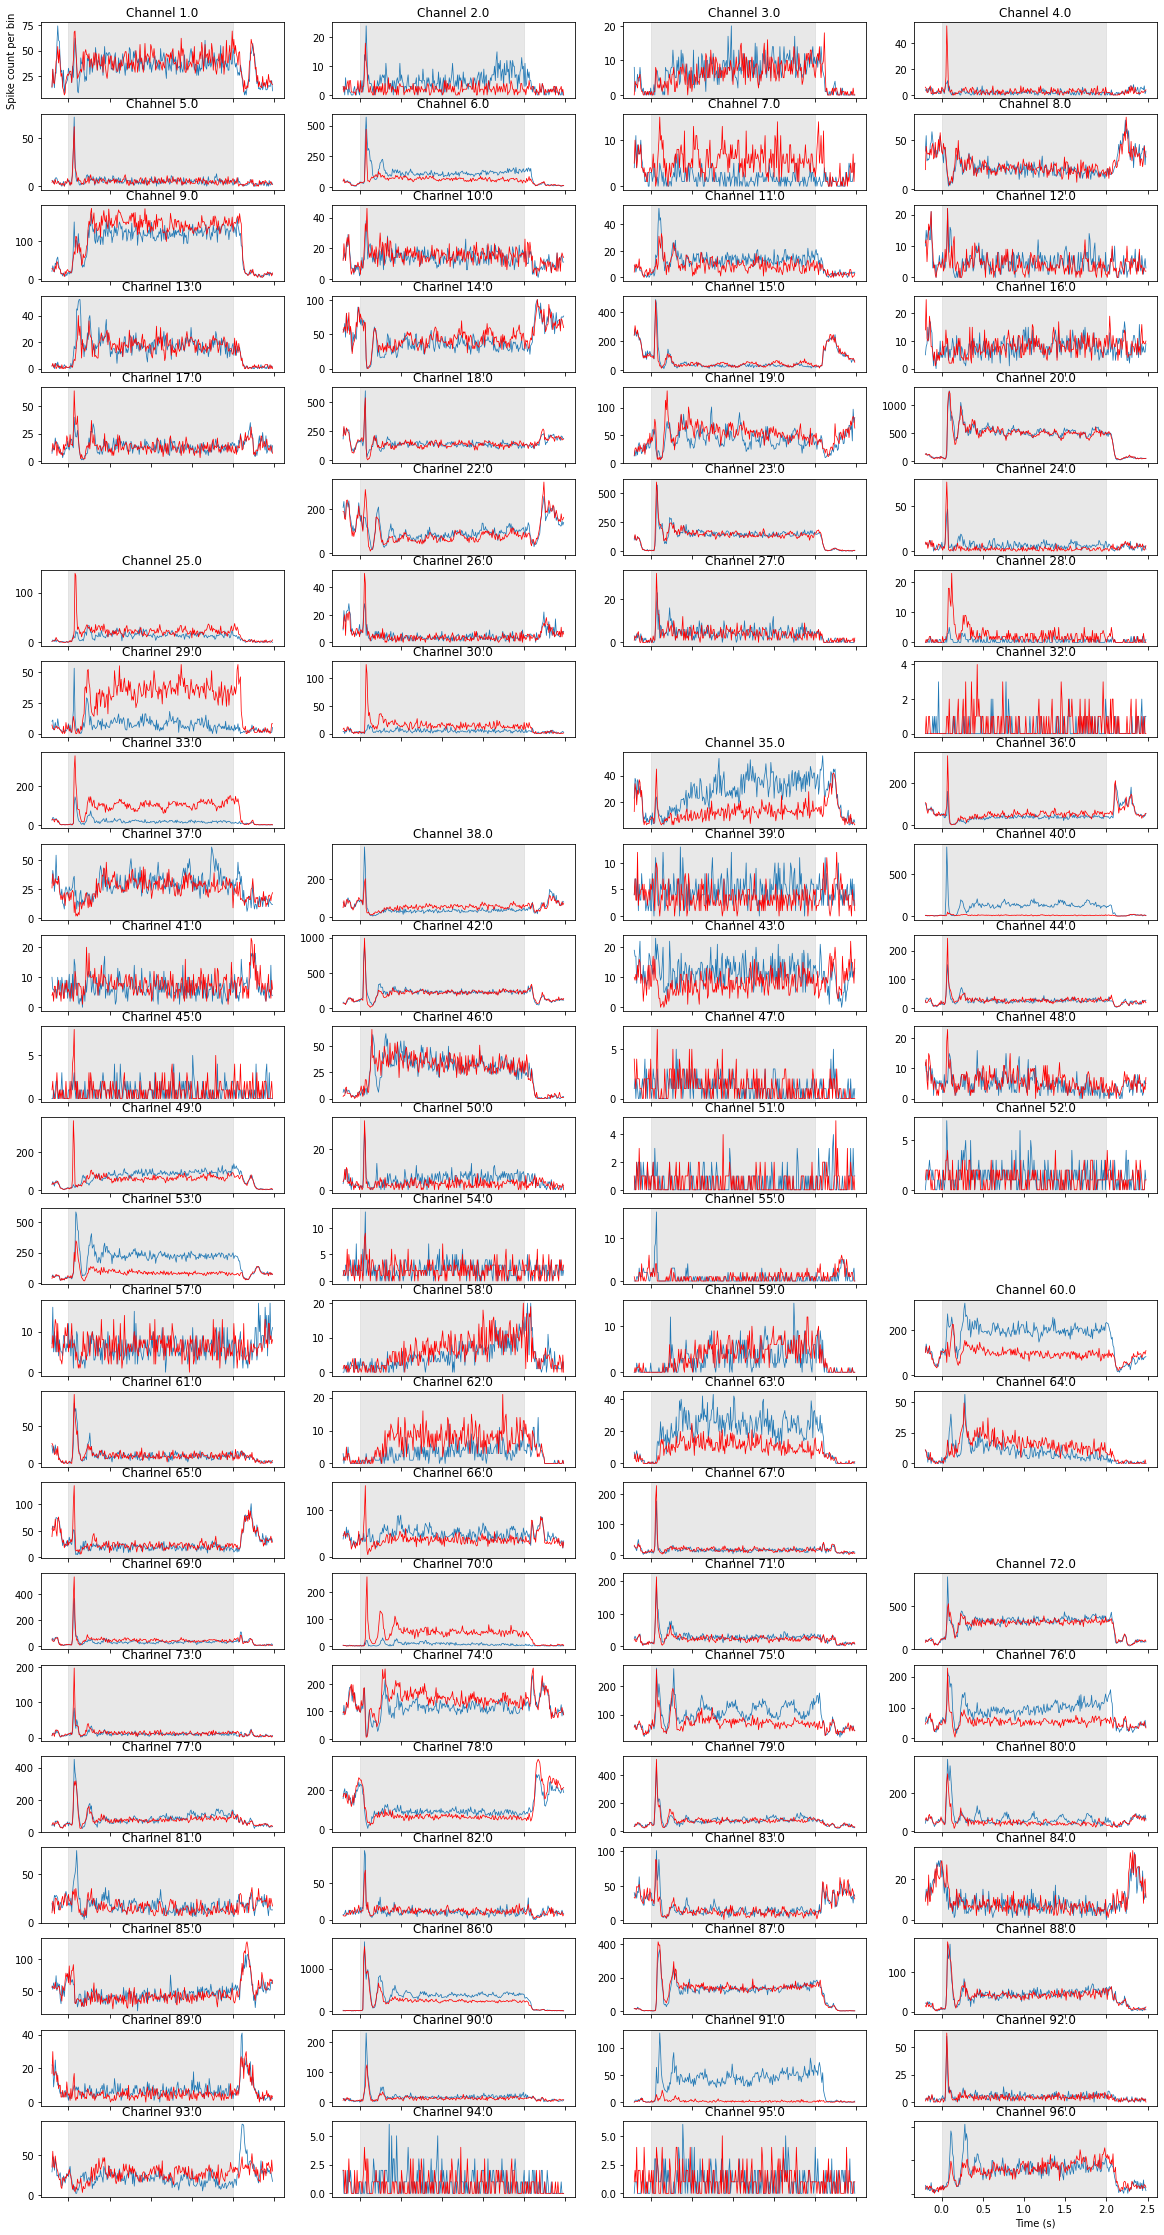

In [31]:
fig = plt.figure(figsize=[20, 40])

for chan in channels:
    ax = fig.add_subplot(int(96/4), 4, int(chan))

    ax.plot(time_bins[:-1], 
           psth.loc[ortn_levs[0], chan],
           linewidth=.75
           )

    ax.plot(time_bins[:-1], 
           psth.loc[ortn_levs[1], chan],
           color='red',
           linewidth=.75
           )

    ax.axvspan(grating_on_time, grating_off_time, alpha=0.5, color='lightgray')
     
    ax.set_title('Channel ' + str(chan))

    # Below we apply axis labels only to first/outside plots to avoid redundancy
    if chan == 1:
        ax.set_ylabel('Spike count per bin')
        ax.set_xlabel('')
        ax.set_xticklabels('')
        
    elif chan == max(channels):
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('')
        ax.set_yticklabels('')
        
    else:
        ax.set_xlabel('')
        ax.set_xticklabels('')
        ax.set_ylabel('')
    
plt.show()    

One thing you'll note above is that there are some missing panels, including channels 21, 31, 34, 56, and 68. As noted above, these are the dead channels. The way the code above is written, we use the channel number as the index for the subplot position. Since there is no channel in the `channels` list for the dead channels, those subplot panels are simply left blank.

Beyond that, it's clear that different channels show very different response profiles. Some (e.g., 1, 2, 4, 5) show clear transient peaks in spiking activity soon after stimulus onset. Others do not. Some of the channels that show this initial peak return to baseline (low) levels of firing soon after, while others (e.g., 1, 20, 72) show a sustained plateau as long as the stimulus is on. Others (e.g., 3, 62) show no initial peak, but a steady rise in firing rate as the stimulus duration increases. As well, a few channels show orientation sensitivity, with clearly different responses between 0 (blue) and 90 (red) degree gratings (e.g., 29, 63, 75, 76, 91).

## Interactive plots

Plotting all 91 channels is a bit visually overwhelming. It's useful in appreciating the whole range of responses in different channels, but each plot is quite small. Here we use `ipywidgets` to generate an interactive plot, with a drop-down menu to select the channel we want to view.

**Note:** This will not display in the online book version, but it should work if you download and run this notebook file. To get this to work on your own system, you will need to at least run `jupyter labextension install @jupyter-widgets/jupyterlab-manager`, and possibly install additional pacakges if you don't have them already (although Anaconda seems to provide them, and they work on the [CoCalc](https://cocalc.com/) cloud platform).

In [32]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

@interact
def psth_i(chan=channels):
    fig = plt.figure(figsize=[15,5]) 

    plt.plot(time_bins[:-1], 
           psth.loc[ortn_levs[0], chan],
           linewidth=.75
           )

    plt.plot(time_bins[:-1], 
           psth.loc[ortn_levs[1], chan],
           color='red',
           linewidth=.75
           )

    plt.axvspan(grating_on_time, grating_off_time, alpha=0.5, color='lightgray')
    plt.title('Channel ' + str(int(chan)))
    plt.xlabel('Time (s)')
    plt.ylabel('Spike count per bin')

    plt.show()

interactive(children=(Dropdown(description='chan', options=(1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0,…